In [64]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib notebook

import matplotlib.units as munits
import matplotlib.dates as mdates
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
import matplotlib.ticker as mticker

import pandas as pd


In [65]:

df = pd.read_csv('COVID19.csv')
df['Date'] = pd.to_datetime(df.Date)
df['yday'] = (df.Date.values.astype('datetime64[D]')-np.datetime64('2020-01-01')).astype('float')

df['active'] = df['Cases'] - df['Recovered'] - df['Deaths']

if 0:
    my_data = np.genfromtxt('COVID19.csv', delimiter=',', converters={0: lambda x: np.datetime64(x)})

    date = np.array([d[0] for d in my_data[1:]])
    cases = np.array([d[1] for d in my_data[1:]])
    deaths = np.array([d[2] for d in my_data[1:]])
    casesVI = np.array([d[3] for d in my_data[1:]])

    recovered = np.array([d[5] for d in my_data[1:]])

    

    hosp = np.array([d[6] for d in my_data[1:]])

    icu = np.array([d[7] for d in my_data[1:]])
    print(cases)
    print(my_data[1:][-1][7])

    tests = np.array([d[4] for d in my_data[1:]])

    print(cases)

In [66]:
df

,Date,Cases,Deaths,Tests,Recovered,Hospitalized,ICU,Vancouver Island,VI Hosp,VI ICU,VI Recovered,VI Deaths,yday,active
0,2020-02-22,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN
1,2020-02-24,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,NaN
2,2020-02-29,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN
3,2020-03-03,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN
4,2020-03-04,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,NaN
5,2020-03-07,18,NaN,6326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN
6,2020-03-09,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN
7,2020-03-12,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,NaN
8,2020-03-13,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN
9,2020-03-14,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN


In [67]:
def fitgrowth(t, cases, ntofit=None):
    good = np.isfinite(t+cases)
    t = t[good]
    cases=cases[good]
    
    if ntofit is None:
        ntofit = y
    tofit = np.where(t>t[-1]-ntofit)[0]
    print(tofit)
    t0 = t[tofit[0]]
    p, cov = np.polyfit(t[tofit]-t0, np.log(cases[tofit]), 1, cov=True)
    print(cov)
    tauhi = 1/(p[0]+np.sqrt(cov[0, 0]))
    print(tauhi)
    taulo = 1 / (p[0]-np.sqrt(cov[0, 0]))
    print(1/(p[0]-np.sqrt(cov[0, 0])))

    tau = 1/p[0]
    
    cases0 = np.exp(p[1])
    doubletime = np.log(2) * tau
    return tau, cases0, doubletime, t0, taulo, tauhi

<IPython.core.display.Javascript object>


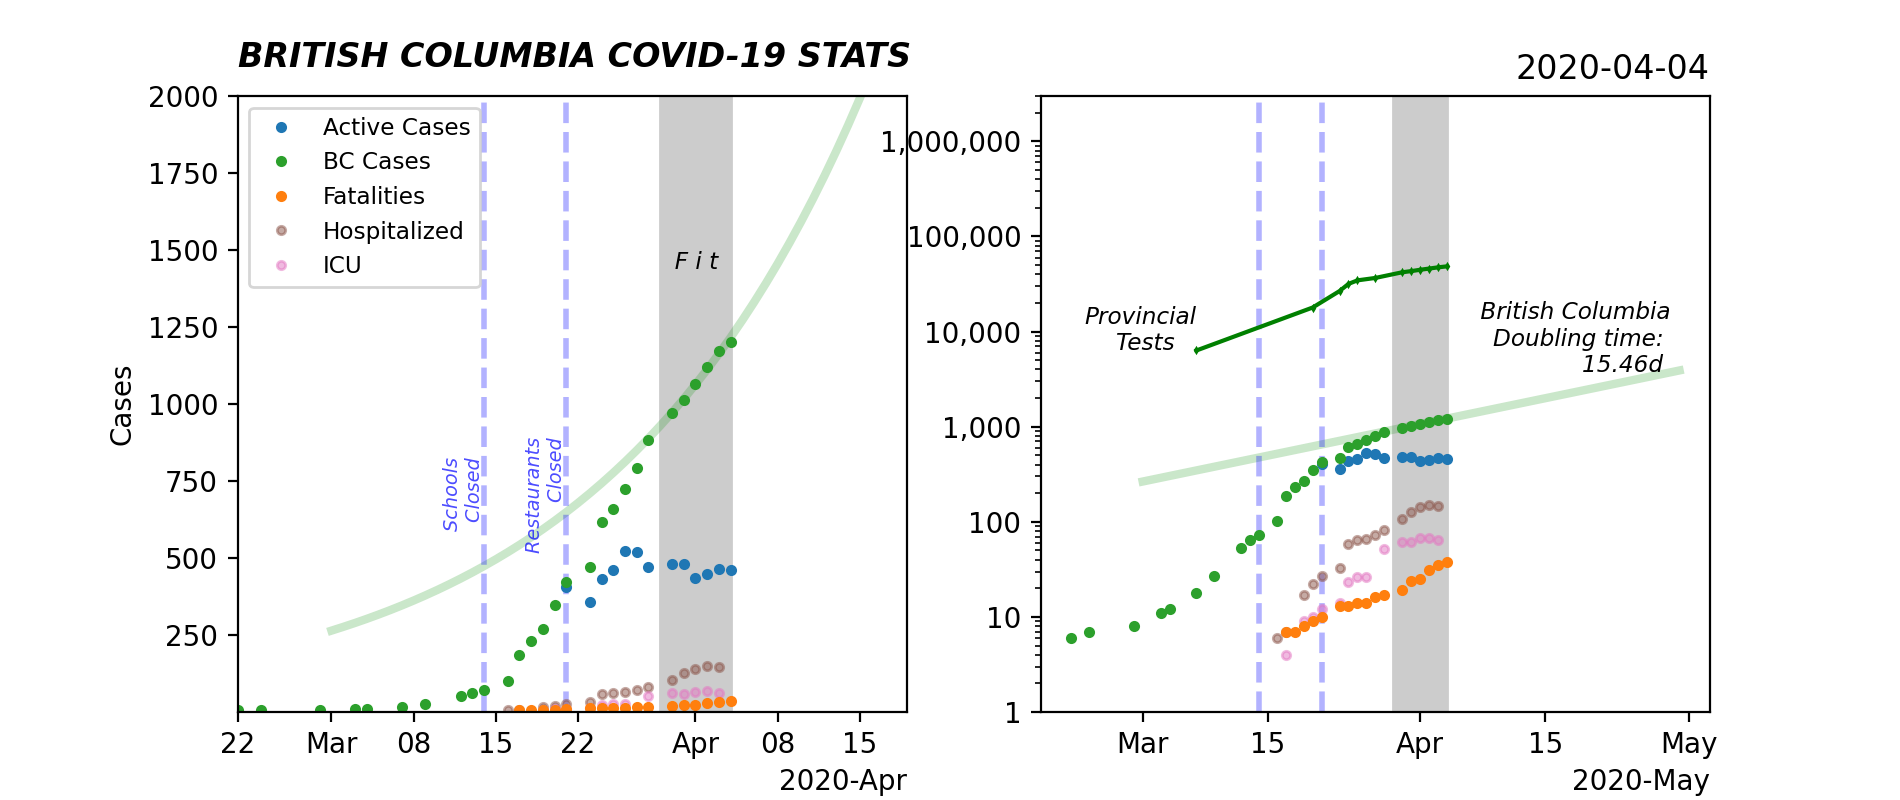

[22 23 24 25 26 27]
[[ 4.24359844e-06 -1.06089961e-05]
 [-1.06089961e-05  3.88996523e-05]]
21.32459207528562
23.378570205279058
[22 23 24 25 26 27]
[[ 4.24359844e-06 -1.06089961e-05]
 [-1.06089961e-05  3.88996523e-05]]
21.32459207528562
23.378570205279058


/Users/jklymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/Users/jklymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.


In [75]:
fig, axs = plt.subplots(1, 2, figsize=(9.5, 4), constrained_layout=True)

for nn in range(2):
    ax = axs[nn]
    
    ax.semilogy(df.Date, df.active, '.', label='Active Cases', color='C0')
    ax.semilogy(df.Date, df.Cases, '.', label='BC Cases', color='C2')
    ax.semilogy(df.Date, df.Deaths, '.', label='Fatalities', color='C1')

    good = np.where(np.isfinite(df.Tests))[0]
    ax.semilogy(df.Date[good], df.Tests[good], 'd-', markersize=1, color='g')
    ax.text(df.Date[good[0]],df.Tests[good[0]], 'Provincial\nTests   ', fontsize='small', fontstyle='italic', ha='right')

    ax.set_ylim(1, 400)
    
    ax.plot(df.Date, df.Hospitalized , '.', zorder=1, color='C5', label='Hospitalized', alpha=0.5)
    ax.plot(df.Date, df.ICU, '.', zorder=1, color='C6', label='ICU', alpha=0.5)
    

    

    tau, cases0, doubletime, t0, taulo, tauhi = fitgrowth(df.yday.values, df.Cases.values, ntofit=7)
    # tau=40
    
    dd = np.arange('2020-03', '2020-05', dtype='datetime64[D]')
    ddy = (dd-np.datetime64('2020-01-01')).astype('float')
    possiblecases = cases0*np.exp((ddy-t0)/tau)
    possiblecases = np.clip(possiblecases, 0, 5e6)
    
    ax.plot(dd, possiblecases, zorder=0, linewidth=3, alpha=0.25, color='C2')

    ind = np.where(dd > np.datetime64('2020-04-28'))[0][0]
    tt = ax.text(dd[ind], possiblecases[ind], f' British Columbia\nDoubling time: \n{np.log(2) * tau:1.2f}d ', 
            ha='right', fontsize='small', fontstyle='italic')
    tt.set_in_layout(False)

    
    if nn == 0:
        ax.set_ylim(1, 2000)
        ax.set_yscale('linear')    
        ax.legend(loc=2, fontsize='small')
    else:
        ax.set_yscale('log')
        ax.set_ylim(1, 3e6)
    ax.axvline(np.datetime64('2020-03-14'), lw=2, color='b', linestyle='--', zorder=0, alpha=0.3)
    ax.axvline(np.datetime64('2020-03-21'), lw=2, color='b', linestyle='--', zorder=0, alpha=0.3)

    if nn==0:
        axs[0].text(np.datetime64('2020-03-14'),600, 'Schools \nClosed ', rotation=90, fontsize='x-small', alpha=0.7, color='b', ha='right', fontstyle='italic')
        axs[0].text(np.datetime64('2020-03-21'),530, 'Restaurants \nClosed ', rotation=90, fontsize='x-small', alpha=0.7, color='b', ha='right',fontstyle='italic')


    ax.axvspan(df.Date.values[-1]-np.timedelta64(6, 'D'), df.Date.values[-1], color='0.8', zorder=-1)
axs[0].text(df.Date.values[-1]-np.timedelta64(6, 'D'), 1440, '  F i t', rotation=0, fontsize='small', fontstyle='italic')
axs[0].set_ylabel('Cases')
tt = axs[0].set_title(f'BRITISH COLUMBIA COVID-19 STATS ', loc='left', y=1.02, fontweight='bold', fontstyle='oblique')
tt.set_in_layout(False)

axs[1].set_title(str(df.Date.values[-1])[:10], loc='right')
axs[0].set_xlim([df.Date[0], df.Date.values[-1]+np.timedelta64(15, 'D')] )




ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
#axs[1].yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
# axs[1].set_ylabel('Cases')

fig.savefig('Cases.pdf')
fig.savefig('Cases.png', dpi=200)

<IPython.core.display.Javascript object>


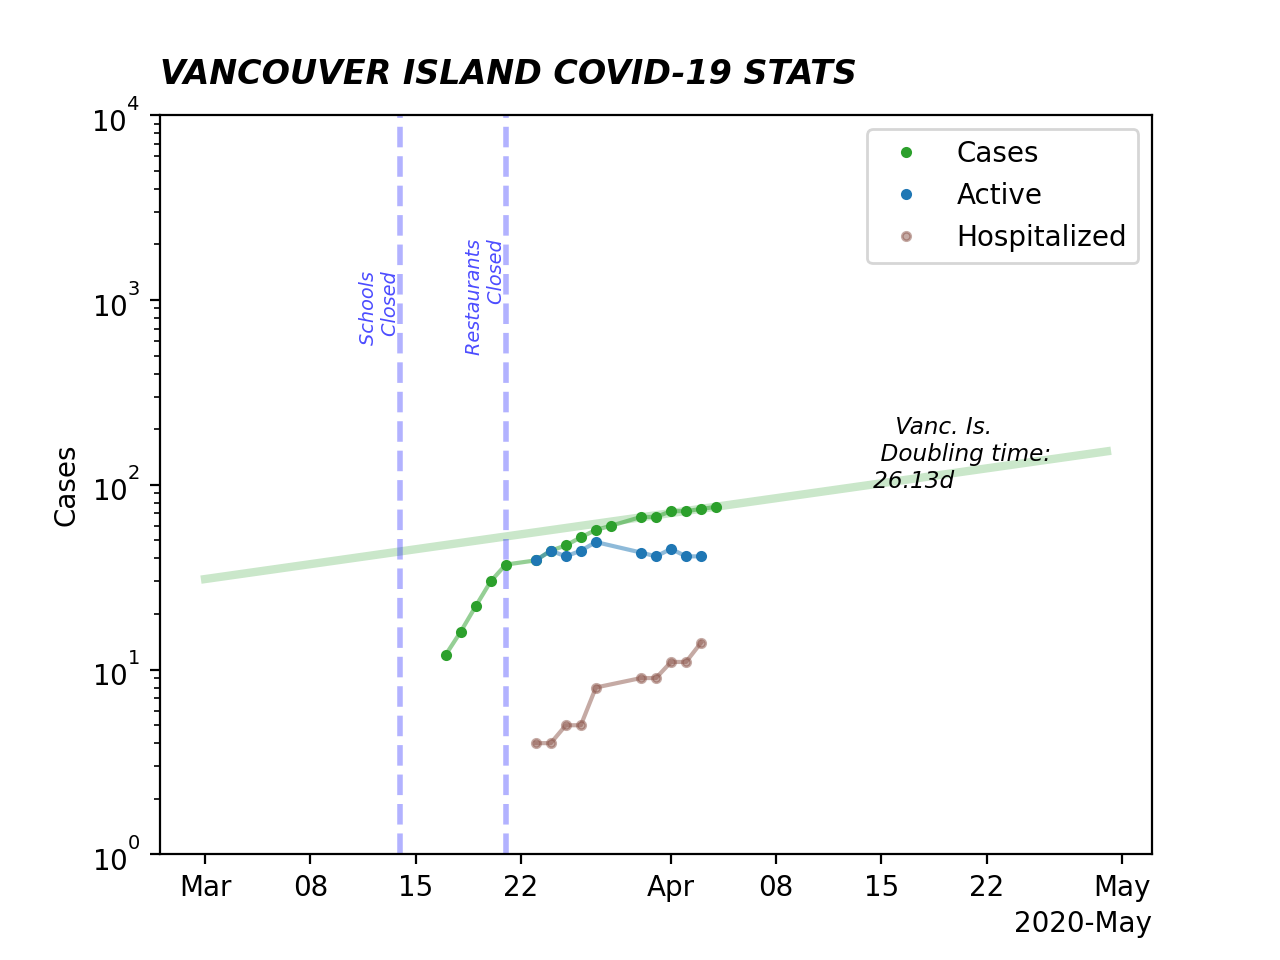

[11 12 13 14 15 16]
[[ 1.53221982e-05 -3.83054955e-05]
 [-3.83054955e-05  1.40453484e-04]]
32.85386853077471
44.22997833981686


Text(0, 0.5, 'Cases')

In [100]:
# VI
fig, ax = plt.subplots()

dfd = df.dropna(subset=['Vancouver Island'])
ax.semilogy(dfd.Date, dfd['Vancouver Island'], '-', color='C2', alpha=0.5)
ax.semilogy(dfd.Date, dfd['Vancouver Island'], '.', label='Cases', color='C2')


df['VIActive'] = df['Vancouver Island'] - df['VI Recovered'] -df['VI Deaths']
dfd = df.dropna(subset=['VIActive'])
ax.semilogy(dfd.Date, dfd['VIActive'] , '-', color='C0', alpha=0.5)
ax.semilogy(dfd.Date, dfd['VIActive'] , '.', label='Active', color='C0')


dfd = df.dropna(subset=['VI Hosp'])
ax.semilogy(dfd.Date, dfd['VI Hosp'] , '-', color='C5', alpha=0.5)
ax.plot(df.Date, df['VI Hosp'] , '.', zorder=1, color='C5', label='Hospitalized', alpha=0.5)
    

tauVI, cases0VI, doubletimeVI, t0, taulo, tauhi = fitgrowth(df.yday.values, df['Vancouver Island'].values, ntofit=7)
fitcases = cases0VI*np.exp((ddy-t0)/tauVI)
fitcases = np.clip(fitcases, 0, 870297)
ax.plot(dd, fitcases, zorder=0, linewidth=3, alpha=0.25, color='C2')

ind = np.where(dd>np.datetime64('2020-04-12'))[0][0]
ax.text(dd[ind], fitcases[ind], f'      Vanc. Is.\n    Doubling time: \n   {np.log(2) * tauVI:1.2f}d ', 
   ha='left', fontsize='small', fontstyle='italic')

# lines
ax.axvline(np.datetime64('2020-03-14'), lw=2, color='b', linestyle='--', zorder=0, alpha=0.3)
ax.axvline(np.datetime64('2020-03-21'), lw=2, color='b', linestyle='--', zorder=0, alpha=0.3)

ax.text(np.datetime64('2020-03-14'),600, 'Schools \nClosed ', rotation=90, fontsize='x-small', alpha=0.7, color='b', ha='right', fontstyle='italic')
ax.text(np.datetime64('2020-03-21'),530, 'Restaurants \nClosed ', rotation=90, fontsize='x-small', alpha=0.7, color='b', ha='right',fontstyle='italic')



ax.legend()

ax.set_ylim([1, 1e4])
ax.axhline(807297)
tt = ax.set_title(f'VANCOUVER ISLAND COVID-19 STATS ', loc='left', y=1.02, fontweight='bold', fontstyle='oblique')
ax.set_ylabel('Cases')


## Current cases

<IPython.core.display.Javascript object>


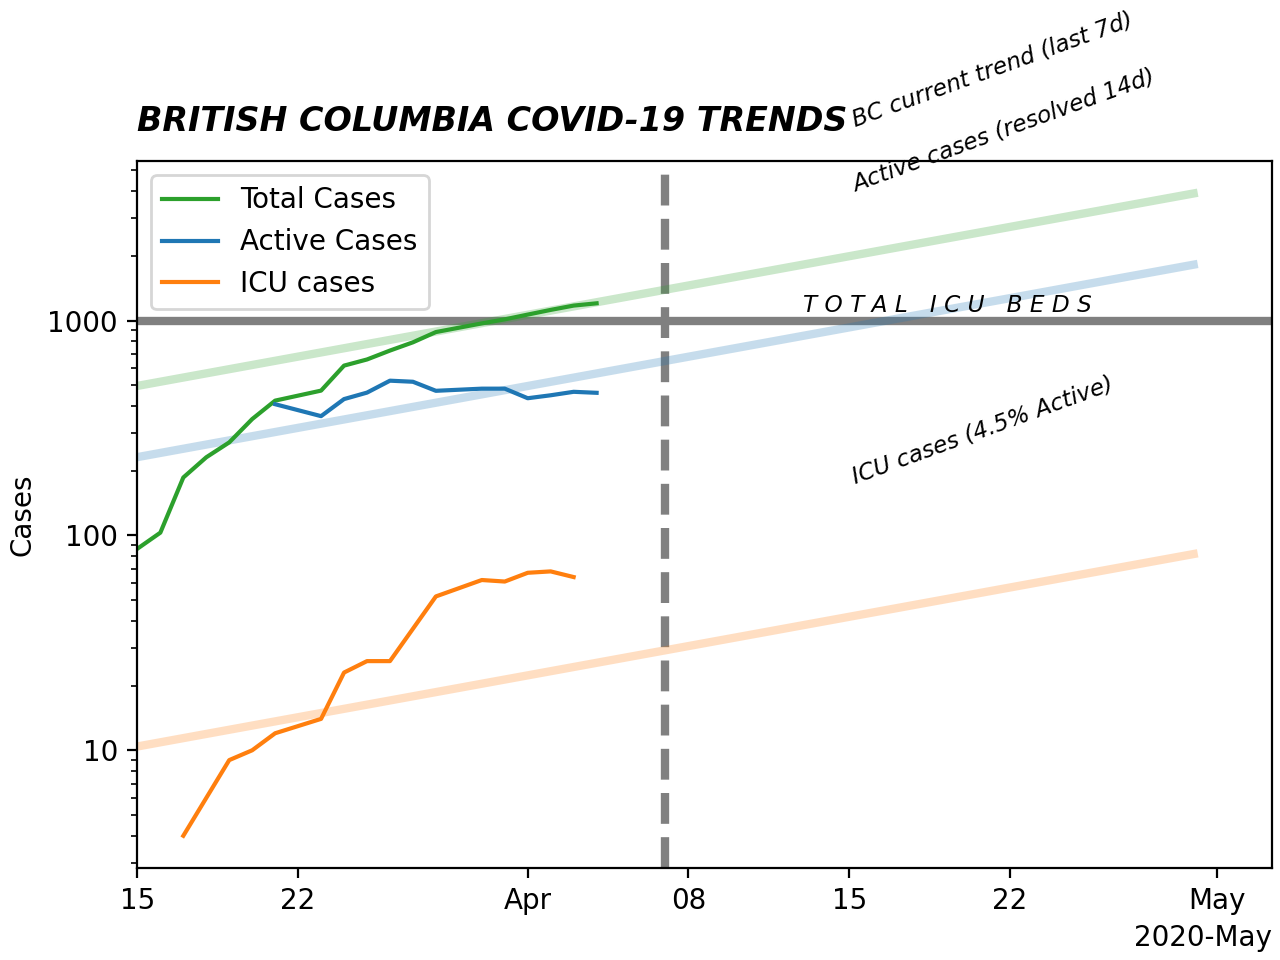

In [101]:
fig, ax = plt.subplots(constrained_layout=True)
currentcases = 0*possiblecases
currentcases[14:] = possiblecases[14:] - possiblecases[:-14]

ax.semilogy(df.Date, df.Cases, color='C2', label='Total Cases')

ax.semilogy(df.Date, df.Cases-df.Recovered-df.Deaths, label='Active Cases')


good = np.where(np.isfinite(df.ICU))[0]
ax.semilogy(df.Date.values[good], df.ICU.values[good], label='ICU cases')


ax.semilogy(dd, possiblecases, zorder=0, linewidth=3, alpha=0.25, color='C2')

ax.semilogy(dd[14:], currentcases[14:], zorder=0, linewidth=3, alpha=0.25, color='C0')

ax.semilogy(dd[14:], currentcases[14:]*0.045, zorder=0, linewidth=3, alpha=0.25, color='C1', )

ax.axhline(1000, linewidth=3, color='0.5', zorder=-3)
ax.text(np.datetime64('2020-04-13'), 1100, 'T O T A L   I C U   B E D S', fontsize='small', fontstyle='italic')

ax.legend()
ax.set_xlim(left=np.datetime64('2020-03-15'))
ax.set_ylabel('Cases')
ax.axvline(np.datetime64('2020-03-28')+np.timedelta64(10, 'D'), linewidth=3, color='0.5', zorder=-3, linestyle='--')


ax.text(np.datetime64('2020-04-15'), 8e3, 'BC current trend (last 7d)', rotation=20, fontsize='small', fontstyle='italic')

ax.text(np.datetime64('2020-04-15'), 4e3, 'Active cases (resolved 14d)', rotation=20, fontsize='small', fontstyle='italic')

ax.text(np.datetime64('2020-04-15'), 1.75e2, 'ICU cases (4.5% Active)', rotation=20, fontsize='small', fontstyle='italic')

ax.set_title(f'BRITISH COLUMBIA COVID-19 TRENDS', loc='left', y=1.02, fontweight='bold', fontstyle='oblique')

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())



fig.savefig('covidtrends19trends.png', dpi=200)

fig.savefig('covidtrends19trends.pdf')





$ c = a\ e^{\frac{t-t_0}{\tau}}$ 

$log(c) = log(a) + (t-t_0)/\tau$

$exp((t-t0)/tau) = 2$
$t-t0 = np.log(2) * tau$


In [20]:
print(icu)

<generator object <genexpr> at 0x11abf1318>
